# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


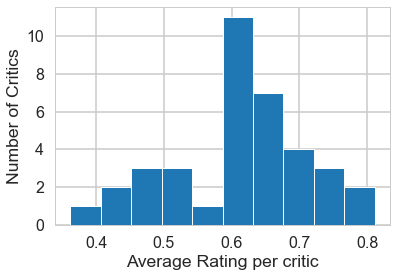

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The Critica rate lots of movies evidenced from the fact that 623 critics created 15561 reviews.

Average ratings per critic roughly follows a normal distribution. Most critics provide 0.6 rating for a movie.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
#Use scikit-learn's MultinomialNB() classifier with default parameters. 
clf = MultinomialNB()

In [9]:
#train the classifier over the training set and test on the test set 
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
#train the classifier over the training set and test on the test set 
print(clf.predict(X_test[2:5]))

[0 1 1]


In [11]:
y_test[2:5]

array([0, 1, 1])

In [12]:
#print the accuracy scores for both the training and the test sets 
print('training accuracy : %2.2f'  %(100*clf.score(X_train,y_train)))
print('testing accuracy  : %2.2f' %(100*clf.score(X_test,y_test)))

training accuracy : 92.28
testing accuracy  : 76.74


The accuracy needs to be improved

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [13]:
# Your turn.
df_df = critics.copy()
df_df.quote = df_df.quote.str.lower()
df_df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [14]:
X_hp,y = make_xy(df_df)

In [15]:
df_word_f = pd.DataFrame(((X_hp>0).sum(axis=0).transpose()).A[:,0])

In [16]:
df_word_f=df_word_f.reset_index()

In [17]:
df_word_f.columns=['word','freq']

In [18]:
df_word_f.word=df_word_f.word+1

In [19]:
df_word_f.head()

,word,freq
0,1,7
1,2,1
2,3,10
3,4,1
4,5,1


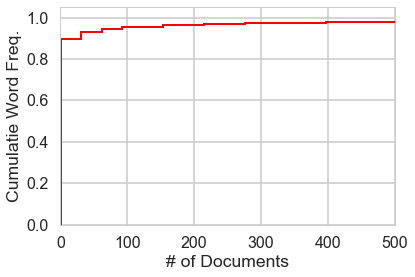

In [20]:
plt.hist(df_word_f.groupby(['freq']).size(),len(df_word_f['freq'].unique()),histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('# of Documents')
plt.ylabel('Cumulatie Word Freq.')
plt.show()

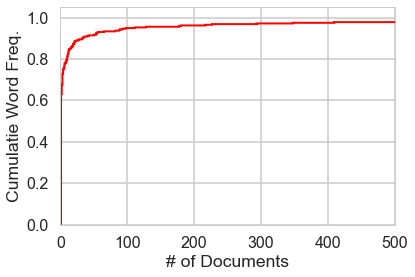

In [21]:
plt.hist(df_word_f.groupby(['freq']).size(),(df_word_f.groupby(['freq']).size()).index[-1],histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('# of Documents')
plt.ylabel('Cumulatie Word Freq.')
plt.show()

Response:
From the curve above that plots the cummulative number of words against the total number of documents in which a word apprears $(df)$, we can see that the curve rises steeply just after 0, so the `min_df` will be something that is close to 0, say, 0.001. The curve starts to plateau around 0.2, this might be a good value for `max_df` against As we can see from the above accuracy scores on testing and training data, there is a lot of overfit. So, this classifier needs to be tweaked to improve accuracy

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [22]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [23]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [24]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/dipanjanbandyopadhyay/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

Response:
What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?

We are trying to maximize the probability. For example, there may be two models that accurately predits a particular class for a given response, but, we would like to chose the model that gives the higher probability for that class.

 

Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?

$\alpha$ is a smoothing parameter, at its lowest value, there will be no smoothing, or the model will overfit the training data. If it is too high, the smoothing is going to be very high leading to lower accuracy

 

Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.

Completed

In [25]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
#min_dfs= [1,5,10,50,60,70,100] ## best 50
min_dfs=[0.00001,0.0001,0.0005,0.0008,0.001,0.003,0.005]#best 0.001
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for mindf in min_dfs:
    for alpha in alphas:        
        vectorizer = CountVectorizer(min_df=mindf)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        print('alpha:',alpha,' min df:',mindf,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=mindf
print('\n','best alpha:',best_alpha,'best min df:',best_min_df,' max score',maxscore)

alpha: 0.1  min df: 1e-05  score: -951.698327902
alpha: 1  min df: 1e-05  score: -720.593766844
alpha: 5  min df: 1e-05  score: -1201.44009238
alpha: 10  min df: 1e-05  score: -1345.99168887
alpha: 50  min df: 1e-05  score: -1307.69037445
alpha: 0.1  min df: 0.0001  score: -954.270947723
alpha: 1  min df: 0.0001  score: -630.004298126
alpha: 5  min df: 0.0001  score: -959.995101587
alpha: 10  min df: 0.0001  score: -1164.68471369
alpha: 50  min df: 0.0001  score: -1257.75367075
alpha: 0.1  min df: 0.0005  score: -854.315005498
alpha: 1  min df: 0.0005  score: -598.254715223
alpha: 5  min df: 0.0005  score: -615.070340016
alpha: 10  min df: 0.0005  score: -769.217195009
alpha: 50  min df: 0.0005  score: -1090.07514041
alpha: 0.1  min df: 0.0008  score: -783.330182339
alpha: 1  min df: 0.0008  score: -596.094875228
alpha: 5  min df: 0.0008  score: -568.336173461
alpha: 10  min df: 0.0008  score: -659.966701648
alpha: 50  min df: 0.0008  score: -999.045833109
alpha: 0.1  min df: 0.001  sc

In [26]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    print('alpha:',alpha,'score:',score)
    if score>maxscore:
        maxscore=score
        best_alpha=alpha
print('\n','best alpha:',best_alpha,'max score',maxscore)

alpha: 0.1 score: -733.288127243
alpha: 1 score: -589.833192168
alpha: 5 score: -559.149302264
alpha: 10 score: -627.202127908
alpha: 50 score: -956.136712526

 best alpha: 5 max score -559.149302264


In [27]:
print("alpha: {}".format(best_alpha))

alpha: 5


In [28]:
logprob = clf.predict_log_proba(Xtrainthis)
prob = clf.predict_proba(Xtrainthis)
temp_pred_df=pd.DataFrame(clf.predict(Xtrainthis))
temp_pred_df.columns=['Prediction']
temp_pred_df['class0LogProb']=logprob[:,0]
temp_pred_df['class1LogProb']=logprob[:,1]
temp_pred_df['class0Prob']=prob[:,0]
temp_pred_df['class1Prob']=prob[:,1]

In [29]:
temp_pred_df[(temp_pred_df.Prediction==0)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
446,0,-0.541031,-0.872627,0.582148,0.417852
487,0,-0.583144,-0.816765,0.558141,0.441859
545,0,-0.678394,-0.708121,0.507431,0.492569
688,0,-0.385312,-1.140179,0.680238,0.319762
941,0,-0.380254,-1.151024,0.683687,0.316313
1032,0,-0.573077,-0.829627,0.563788,0.436212
1178,0,-0.581508,-0.818835,0.559055,0.440945
1254,0,-0.648894,-0.739450,0.522624,0.477376
1489,0,-0.608987,-0.785046,0.543901,0.456099
1490,0,-0.563672,-0.841915,0.569115,0.430885


In [30]:
temp_pred_df[(temp_pred_df.Prediction==1)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
0,1,-1.747075,-0.191503,0.174283,0.825717
1,1,-4.568625,-0.010426,0.010372,0.989628
2,1,-1.208985,-0.354534,0.298500,0.701500
3,1,-0.845746,-0.560781,0.429237,0.570763
4,1,-3.159176,-0.043389,0.042461,0.957539
5,1,-1.122486,-0.393739,0.325470,0.674530
6,1,-2.952366,-0.053629,0.052216,0.947784
7,1,-2.025783,-0.141437,0.131891,0.868109
8,1,-5.283902,-0.005086,0.005073,0.994927
9,1,-2.456042,-0.089677,0.085774,0.914226


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [31]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.803170
Accuracy on test data:     0.719978


In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2139 2108]
 [ 942 5703]]


The accuracy of this classifier is less than the original model. However, this is less overfit than the original model


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [33]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
           excellent 0.84
         intelligent 0.84
               great 0.84
            touching 0.84
         masterpiece 0.83
               gives 0.83
           effective 0.83
               smart 0.83
        entertaining 0.83
           wonderful 0.82
Bad words	     P(fresh | word)
                 bad 0.29
           pointless 0.28
              cliche 0.28
               fails 0.28
               flick 0.27
               bland 0.27
                  tv 0.26
                dull 0.26
       unfortunately 0.26
                lame 0.23


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Response:
This method builds a review with just one word and tries to classify the review based on that one word. The probability for each row gives the probability that the review will be classified as $fresh$ or $rotten$


The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [34]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
While Leone's vision still has a magnificent sweep, the film finally subsides to an emotional core that is sombre, even elegiac, and which centres on a man who is bent and broken by time, and finally left with nothing but an impotent sadness.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Herzog offers some evidence of Kinski's great human warmth, somewhat more of his rage of unimaginable proportions, and a good demonstration of Kinski's uncanny capacity to corkscrew his way into the frame.

With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble.

Alfred Hitchcock's 1966 spy thriller has one 

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [35]:
string = ['This movie is not remarkable, touching, or superb in any way']
x_test_q7 = vectorizer.transform(string)
print('Review -','\n',string,'\n')
if clf.predict(x_test_q7)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,0]))
print('---------------------------------','\n')
        
#lets check what happens if we include a lot of 'Bad' words like uninspired, bad, worst
string_another_review = ['This movie is uninspired, bad and has been the worst movie that i have ever seen']
x_test_q7_2 = vectorizer.transform(string_another_review)
print('Review -','\n',string_another_review,'\n')
if clf.predict(x_test_q7_2)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,0]))
print('---------------------------------','\n')

Review - 
 ['This movie is not remarkable, touching, or superb in any way'] 

predicted as Fresh with a probability of  91.28
--------------------------------- 

Review - 
 ['This movie is uninspired, bad and has been the worst movie that i have ever seen'] 

predicted as Rotten with a probability of  91.32
--------------------------------- 



Response:
The given review should have been classified as $Rotten$, given what the critic has said about the movie. The critic has slammed the movie by saying that the movie is the opposite of all good things about a movie. However, the classifier has classified this as a $Fresh$ movie, because it contains a lot of Good words, or strong words that make the model classify the review as $Fresh$




Response:
Below is an implementation of Naive Bayes with n-grams.This uses 1,2 n-grams

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [36]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [37]:

#your turn
def clf_score(clf, x, y):
    score = clf.score(x,y)
    return score

In [38]:
def find_good_bad_words(vctrzr,clfr):
    words = np.array(vctrzr.get_feature_names())
    x = np.eye(len(words))
    probs = clfr.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))


Response:
Below is an implementation of Naive Bayes with n-grams.This uses 1,2 n-grams


In [39]:
from sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
ngrm_min_df = [0,0.00009,0.0001,0.001,0.005,0.01]
best_score=-np.inf
best_alpha, best_min_df = None, None
for alpha in alphas:
    for min_df in ngrm_min_df:
        vectorizer_n2 = CountVectorizer(min_df=min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer_n2)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print('alpha :',alpha,' min_df :',min_df,' score :',score)
        if score > best_score:
            best_score=score
            best_alpha = alpha
            best_min_df = min_df

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

alpha : 1  min_df : 0  score : 0.696933976879
alpha : 1  min_df : 9e-05  score : 0.727136794802
alpha : 1  min_df : 0.0001  score : 0.727136794802
alpha : 1  min_df : 0.001  score : 0.719212046517
alpha : 1  min_df : 0.005  score : 0.675518176039
alpha : 1  min_df : 0.01  score : 0.657524138707
alpha : 5  min_df : 0  score : 0.623466931062
alpha : 5  min_df : 9e-05  score : 0.639744004627
alpha : 5  min_df : 0.0001  score : 0.639744004627
alpha : 5  min_df : 0.001  score : 0.704856889085
alpha : 5  min_df : 0.005  score : 0.671448735515
alpha : 5  min_df : 0.01  score : 0.654739265247
alpha : 10  min_df : 0  score : 0.614042564911
alpha : 10  min_df : 9e-05  score : 0.617897643163
alpha : 10  min_df : 0.0001  score : 0.617897643163
alpha : 10  min_df : 0.001  score : 0.674013967974
alpha : 10  min_df : 0.005  score : 0.671233225693
alpha : 10  min_df : 0.01  score : 0.651955309827
alpha : 50  min_df : 0  score : 0.608259373759
alpha : 50  min_df : 9e-05  score : 0.608473506522
alpha : 

In [40]:
vectorizer_n2 = CountVectorizer(min_df=best_min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001)  
X, y = make_xy(critics, vectorizer_n2)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.976440
Accuracy on test data:     0.743941


In [41]:
find_good_bad_words(vectorizer_n2,clf)

Good words	     P(fresh | word)
            touching 0.96
             a sweet 0.95
              finest 0.95
             delight 0.95
         a wonderful 0.94
              of our 0.94
              richly 0.94
             that we 0.94
            haunting 0.94
            intimate 0.94
Bad words	     P(fresh | word)
              has no 0.13
                save 0.12
            not very 0.12
             tedious 0.12
            annoying 0.12
               hated 0.11
              cliche 0.11
           pointless 0.11
               bland 0.10
                lame 0.07


Response:
Below is an implementation of Random Forest Classifier with n-grams.This uses 1,2 n-grams

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
mindfs=[0.00001,0.0005,0.0001,0.001]
#mindfs=[0.0005,0.0001]
for mindf in mindfs:
    vectorizer = CountVectorizer(min_df=mindf,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    Xtestthis = Xthis[~mask]
    ytestthis = ythis[~mask]
    feat=np.sqrt(len(vectorizer.get_feature_names()))
    parameters = {"n_estimators": [10,20,40,50,60,70],"max_features":['auto','sqrt','log2']}
    clf = RandomForestClassifier()
    fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
    fitmodel.fit(Xtrainthis, ytrainthis)
    print('-------min_df:',mindf)
    print('***best estimator:',fitmodel.best_estimator_)
    print('***best params:',fitmodel.best_params_)
    print('***best score:',fitmodel.best_score_)
    print('***grid scores:', fitmodel.grid_scores_)
    #score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
    #print(score)

/Users/dipanjanbandyopadhyay/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dipanjanbandyopadhyay/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


-------min_df: 1e-05
***best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
***best params: {'max_features': 'auto', 'n_estimators': 20}
***best score: 0.652816448918398
***grid scores: [mean: 0.64896, std: 0.01643, params: {'max_features': 'auto', 'n_estimators': 10}, mean: 0.65282, std: 0.00968, params: {'max_features': 'auto', 'n_estimators': 20}, mean: 0.64082, std: 0.00386, params: {'max_features': 'auto', 'n_estimators': 40}, mean: 0.63997, std: 0.01071, params: {'max_features': 'auto', 'n_estimators': 50}, mean: 0.63868, std: 0.01050, params: {'max_features': 'auto', 'n_estimators': 60}, mean: 0.63675

In [ ]:
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
feat=np.sqrt(len(vectorizer.get_feature_names()))
parameters = {"n_estimators": [60,80,100,150,250],"max_features":['auto','sqrt','log2']}
clf = RandomForestClassifier()
fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(Xtrainthis, ytrainthis)
print('-------min_df:',mindf)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
clf = fitmodel.best_estimator_
score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
print(score)

0.678943611706


In [45]:
training_accuracy = clf.score(Xtrainthis, ytrainthis)
test_accuracy = clf.score(Xtestthis, ytestthis)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.933176
Accuracy on test data:     0.684080


Response:
Below is an implementation of Naive Bayes that uses TF-IDF for classification

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=1).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.844078
Accuracy on test data:     0.670033


In [47]:
rom sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
min_dfs = [0,0.00009,0.0001,0.001,0.005,0.01]
#min_dfs = [0,0.00009,0.0001,0.001]
best_score=-np.inf
best_alpha,best_min_df = None,None

for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df,analyzer='word',stop_words='english',
                                          ngram_range=(1, 4),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print(' min_df :',min_df,'alpha:',alpha,' score :',score)
        if score > best_score:
            best_score=score
            best_min_df = min_df
            best_alpha = alpha

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

SyntaxError: invalid syntax (<ipython-input-47-fa2015e0c1e9>, line 1)

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df,analyzer='word',stop_words='english',
                                  ngram_range=(1, 4),token_pattern=r'\b\w+\b')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
find_good_bad_words(tfidfvectorizer,clf)

Response:
Below is an implementation of LDA for classification

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
vectorizer_lda = CountVectorizer(min_df=0.00009,ngram_range=(1, 2),token_pattern=r'\b\w+\b') 

X, y = make_xy(critics, vectorizer_lda)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

In [ ]:
lda = LDA(n_topics=20)
lda.fit(xtrain)
training_features = lda.transform(xtrain)
testing_features=lda.transform(xtest)
xtrain_trn_feat=sp.sparse.hstack((xtrain,sp.sparse.csc_matrix(training_features)))
xtest_tst_feat=sp.sparse.hstack((xtest,sp.sparse.csc_matrix(testing_features)))

#clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)

In [ ]:
clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain_trn_feat, ytrain)
test_accuracy = clf.score(xtest_tst_feat, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))